# Initialization

In [1]:
!pip install ffmpeg-python
!pip install sounddevice
!pip install scipy
!pip install sounddevice

import matplotlib.pyplot as plt
from IPython.display import HTML, Audio
from base64 import b64decode
import numpy as np

import struct

from scipy.io.wavfile import read as wav_read
from scipy import signal
from scipy.signal import chirp

import io
import ffmpeg

import sounddevice as sd
import matplotlib.pyplot as plt

import time
import numpy as np
from scipy.io import wavfile

# Filter Functions

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutoff / nyq
    b, a = signal.butter(order, normalCutoff, btype='low')
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

# Task 1.1 : Single tone signal processing



In [3]:
def play_and_record(freq,sample_rate,duration,sd):    
    
    sd.default.channels   = 1
    sd.default.samplerate = sample_rate
    
    #TODO implement this function (hint: look up np.linspace)
    t = np.linspace(0,duration, duration * sample_rate)
    x = np.sin(2 * np.pi * freq * t)
    y = sd.playrec(x)
    
    return y

In [9]:
freq         = 10000 # single tone frequency in Hz
sample_rate  = 48000 # sampling rate in samples/s
duration     = 2     #in seconds

rec = play_and_record(freq,sample_rate,duration,sd)

Let us see how the recorded signal looks like in time, frequency and how does the spectrogram look like.

Text(0.5, 1.0, 'Time domain')

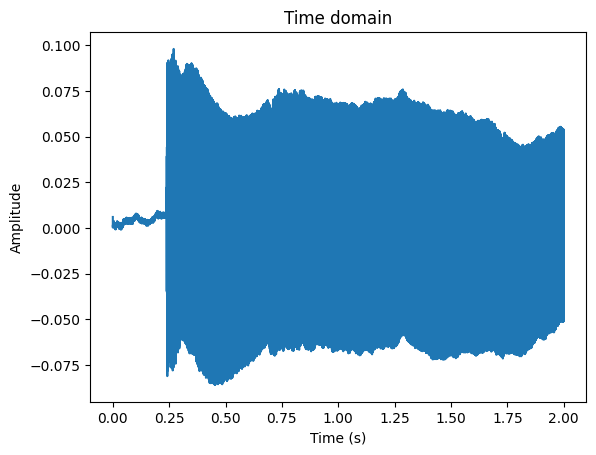

In [10]:
t = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
plt.plot(t,rec)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time domain")

Text(0.5, 1.0, 'Frequency Domain')

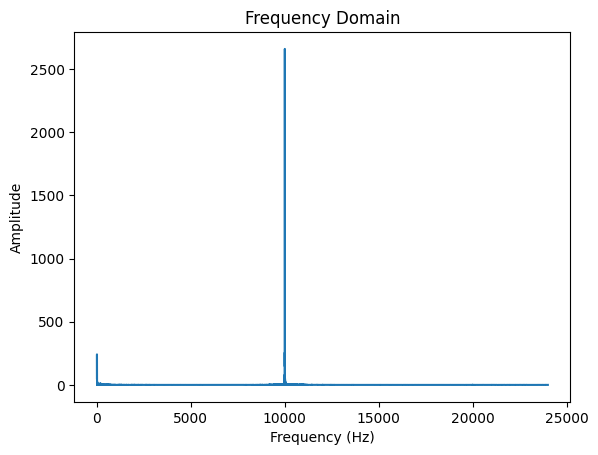

In [11]:
window_length = rec.shape[0]

rec2 = rec[:,0]

fft = np.abs(np.fft.rfft(rec2)) # Frequency Domain 
freqs = np.multiply(np.fft.rfftfreq(window_length), sample_rate)

plt.plot(freqs,fft)                                     
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain")

Text(0.5, 1.0, 'Spectrogram')

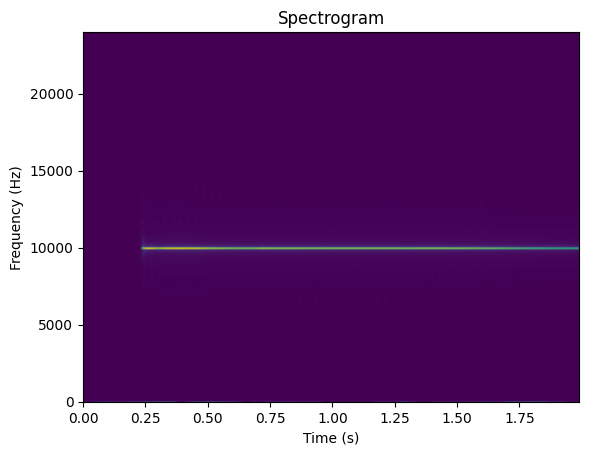

In [12]:
window_length = 500
num_windows = int(np.size(rec2) / window_length)
split_sound = np.array(np.split(rec2,num_windows))
#print(rec2.shape)
#print(split_sound.shape)
spec = np.abs(np.apply_along_axis(np.fft.rfft, 1, split_sound))
freqs               = np.multiply(np.fft.rfftfreq(window_length), sample_rate)
t =  np.linspace(0, duration, num_windows, endpoint=False)
plt.pcolormesh(t, freqs, np.transpose(spec), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")

If you did everything correctly, you should see a peak in the frequency domain representation and a bright horizontal line (at y = 10,000 Hz) in the spectrogram, you can also change the frequency above and make sure that the plots are changing accordingly

# Task 1.2 FMCW signal processing


In [13]:
def play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_duration,total_duration,sd):

    sd.default.channels   = 1
    sd.default.samplerate = sample_rate
    #TODO implement this function
    # for i in range(int(total_duration/chirp_duration)):
    t = np.linspace(0, chirp_duration, int(chirp_duration * sample_rate))
    tx = chirp(t, f0=freq_low, f1=freq_high, t1=chirp_duration,method='linear').astype(np.float32)
    tx = 500*np.tile(tx, int(total_duration/chirp_duration))
    rx = sd.playrec(tx)


    return tx,rx,t

In [40]:
sample_rate = 48000
freq_low    = 17000
freq_high   = 23000

chirp_length   = .05
total_duration = 5   # extend final sound file to "total_duration" seconds

tx,rx,t = play_and_record_chirp(freq_low,freq_high,sample_rate,chirp_length,total_duration,sd)

#### Now we will segment our signal into small parts where each part will contain atmost 1 FMCW chirp signal. We will focus on one of these segments for now and we will also plot the FFT of this segment (recieved FMCW chirp)

Text(0.5, 1.0, 'Frequency Domain - Recieved FMCW signal')

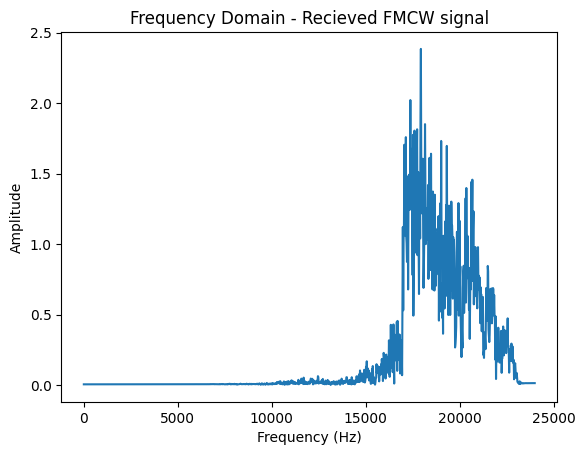

In [41]:
tx_sig = tx;
rx_sig = rx[:,0]

num_chirps_recorded = int(rx_sig.shape[0] // (chirp_length * sample_rate))

# trim audio to a whole number of chirps recorded
rx_sig = rx_sig[:int(num_chirps_recorded * chirp_length * sample_rate)]

rx_data = np.array(np.split(rx_sig, num_chirps_recorded))
tx_data = np.tile(tx_sig[0:int(chirp_length*sample_rate)], (num_chirps_recorded, 1))

# drop the first 5
#rx_data = rx_data[5:]
#tx_data = tx_data[5:]

time_to_drop = 1
segments_to_drop = int(time_to_drop/chirp_length)
rx_data = rx_data[segments_to_drop:]
tx_data = tx_data[segments_to_drop:]

window_length = rx_data.shape[1]

sample_index = 0

rx_data_sample = rx_data[sample_index]
tx_data_sample = tx_data[sample_index]


fft = np.abs(np.fft.rfft(butter_bandpass_filter(rx_data_sample, freq_low, freq_high, sample_rate)))
freqs = np.multiply(np.fft.rfftfreq(window_length), sample_rate)

plt.plot(freqs, fft)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('Frequency Domain - Recieved FMCW signal')

#### Great! Now we can mix this recieved signal with the transmitted signal and we should see a strong peak at a very low frequency, can you think of a reason of why we get this peak?

Text(0.5, 1.0, 'Frequency Domain - Downconverted FMCW signal ')

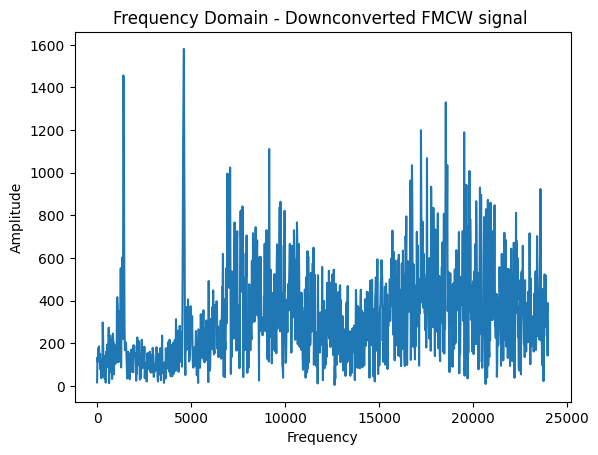

In [42]:
multiplied = np.multiply(rx_data_sample, tx_data_sample)
multiplied_fft = np.abs(np.fft.rfft(multiplied))

plt.plot(freqs, multiplied_fft)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency Domain - Downconverted FMCW signal ")

#### Let us filter everything else (i.e. use a low pass filter) so that we can zoom in on this peak and let us record the peak location, how can we map this peak location to a distance? 

70


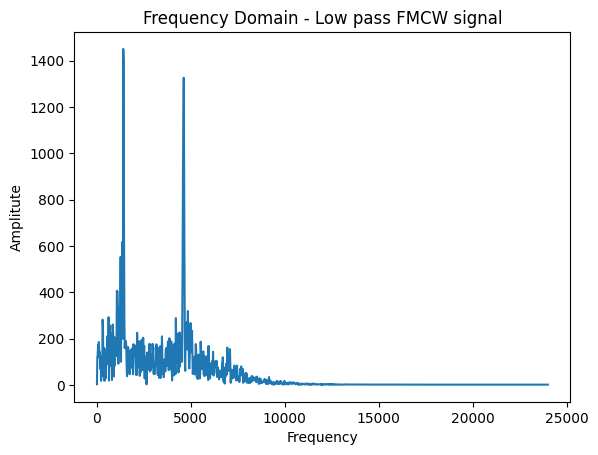

In [43]:
multiplied_fft = np.abs(np.fft.rfft(butter_lowpass_filter(multiplied, 5000, sample_rate)))
peak_location = np.argmax(multiplied_fft)

plt.plot(freqs, multiplied_fft)
plt.xlabel("Frequency")
plt.ylabel("Amplitute")
plt.title("Frequency Domain - Low pass FMCW signal")

print(peak_location)

#### Now we will repeat the same steps for all of the segments and let us also see how the spectrogram changes over time

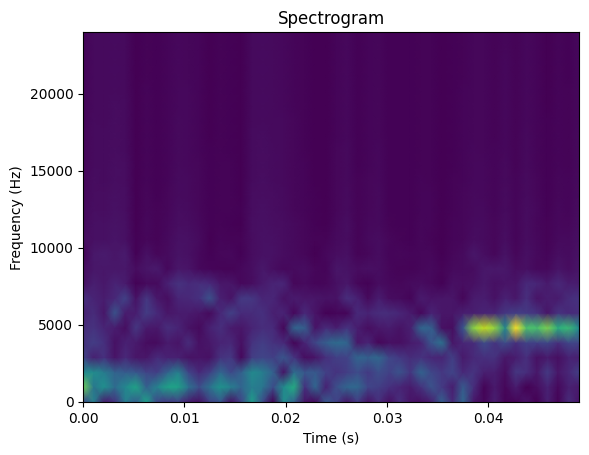

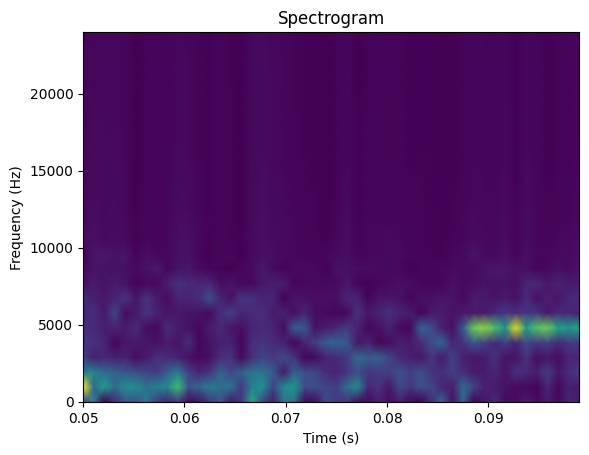

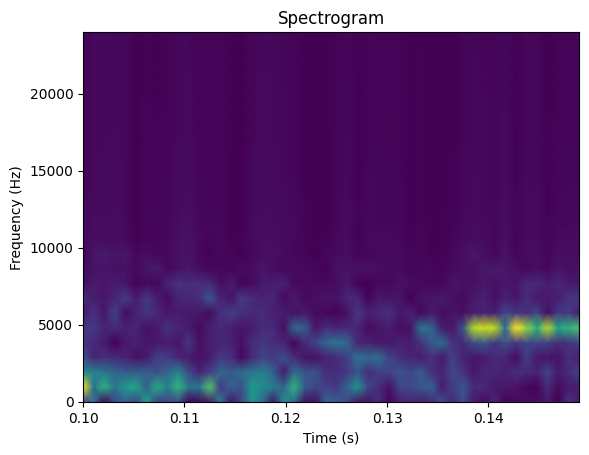

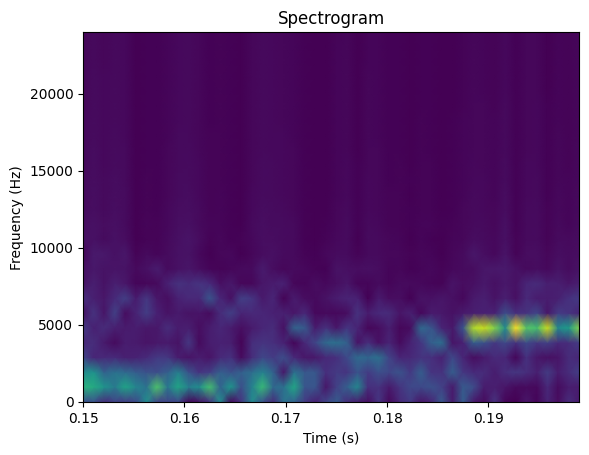

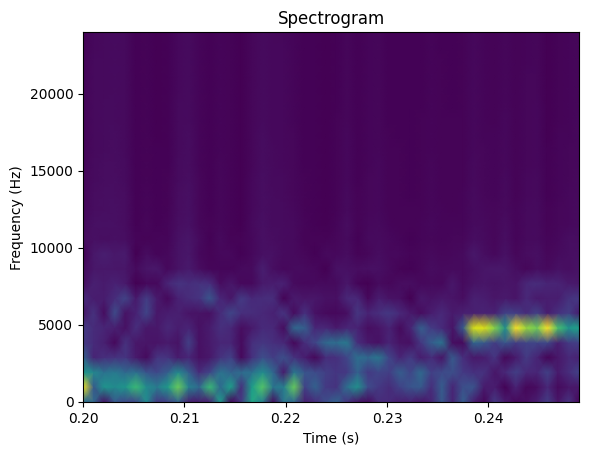

In [44]:
all_multiplied = np.multiply(rx_data, tx_data)

lowpass_cutoff = 5000  

all_multiplied      = np.apply_along_axis(lambda x: butter_lowpass_filter(x, lowpass_cutoff, sample_rate), 1, all_multiplied)
all_multiplied_ffts = np.abs(np.apply_along_axis(np.fft.rfft, 1, all_multiplied))

t_stamp = 0
for s_indx in range(5):
    rec2 = all_multiplied[s_indx]
    split_sound = np.array(np.split(rec2,int(np.size(rec2) / 50)))

    spec = np.abs(np.apply_along_axis(np.fft.rfft, 1, split_sound))
    window_length       = 50
    freqs               = np.multiply(np.fft.rfftfreq(window_length), sample_rate)
    
    t =  np.linspace(t_stamp, t_stamp+0.05, 48, endpoint=False)
    t_stamp = t_stamp + 0.05;

    plt.figure(s_indx)
    plt.pcolormesh(t, freqs, np.transpose(spec), shading='gouraud')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Spectrogram")

# Task 2.1 Background Subtraction


In [45]:
def background_subtract(all_multiplied_ffts):
    
    #TODO: subtract consectutive fft segments and store them in "after_subtraction" variable
    after_subtraction = []
    for i in range(1, all_multiplied_ffts.shape[0]):
        after_subtraction.append(np.abs(all_multiplied_ffts[i] - all_multiplied_ffts[i-1]))
    after_subtraction = np.array(after_subtraction)
    return after_subtraction 
    

In [46]:
subtracted = background_subtract(np.fft.fftshift(all_multiplied_ffts, axes=(1,)))
all_peak_locations = np.apply_along_axis(np.argmax, 1, np.fft.fftshift(all_multiplied_ffts, axes=(1,)))
print(all_peak_locations)

[670 670 670 670 670 670 670 670 670 671 671 671 671 671 670 671 670 670
 670 670 670 670 671 670 670 670 671 670 670 670 670 670 670 670 670 670
 670 671 671 670 671 670 671 671 670 670 670 670 670 671 670 670 671 670
 670 670 670 670 670 671 670 671 671 670 671 670 670 671 671 670 670 671
 671 670 670 670 670 670 670 670]


Text(0.5, 1.0, 'After background subtraction')

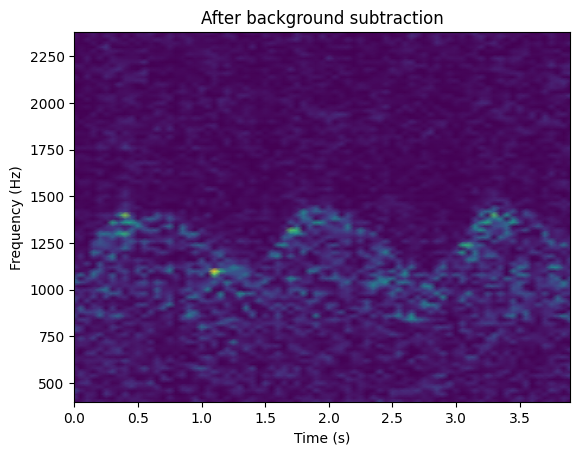

In [47]:
median_peak_location = int(np.median(all_peak_locations))
peak_window_size     = 100
window_range_start   = median_peak_location - peak_window_size/2
window_range         = np.arange(window_range_start,
                         window_range_start + peak_window_size,
                         dtype=np.int32)

window_length       = rx_data.shape[1]
freqs               = np.multiply(np.fft.rfftfreq(window_length), sample_rate)
subtracted_filtered = subtracted[:, window_range]


t = np.arange(subtracted_filtered.shape[0])*0.05
freqs = freqs - np.max(freqs)/2

plt.pcolormesh(t, freqs[window_range], subtracted_filtered.T, shading='gouraud')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('After background subtraction')

In [48]:
# Returns the moving average of the input signal
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# like argmax, but returns the mean of the largest n values
def get_largest_n_mean(array, n):
    return np.mean(np.argpartition(array, -n)[-n:])

Text(0.5, 1.0, 'Peak Locations')

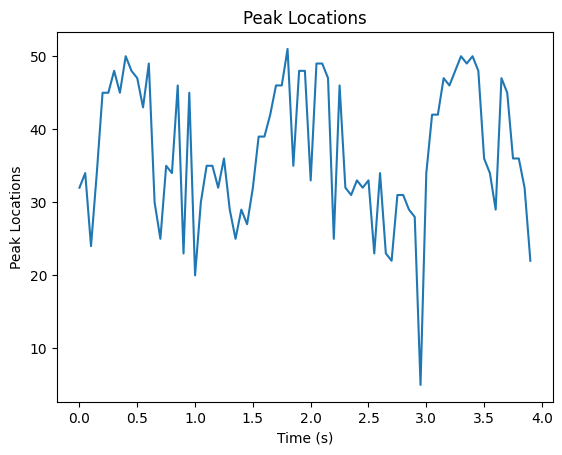

In [49]:
# calculate the peak distance
#print(subtracted_filtered.shape)
#MEAN_WINDOW = 2     # use the largest `MEAN_WINDOW` values instead of a single argmax

argmaxes = np.apply_along_axis(np.argmax, 1, subtracted_filtered)
#mean_argmaxes = np.apply_along_axis(lambda x: get_largest_n_mean(x, MEAN_WINDOW), 1, subtracted_filtered)
plt.plot(t, argmaxes)
plt.xlabel('Time (s)')
plt.ylabel('Peak Locations')
plt.title('Peak Locations')
#plt.plot(mean_argmaxes)

In [50]:
def get_distance_from_peak(idx):
    # use global values
    return idx + window_range_start - median_peak_location

In [217]:
window_range_start

614.0

In [218]:
median_peak_location

664

# Task 2.2 Converting Peak Values to Distance Estimates


In [51]:

def idx_to_distance(idx):
    
    #TODO implement the equation above
    distance = (idx/1201.0)* 0.1 * 343.0 # in meters (idx/1201.0)* (48000/2) * (0.05/6000.0) * 343.0/2
    return distance


Text(0.5, 1.0, 'Distance variation')

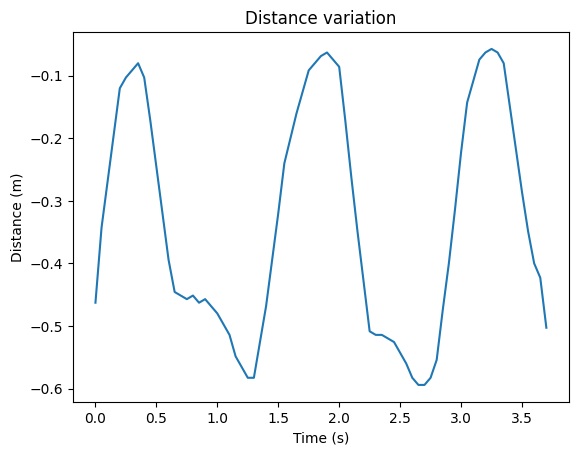

In [52]:
MOVING_AVERAGE_LENGTH = 5
MEDIAN_FILTER_LENGTH  = 7

med_filtered = signal.medfilt(argmaxes, MEDIAN_FILTER_LENGTH)
argmax_distances_med = np.apply_along_axis(get_distance_from_peak, 0, med_filtered)
argmax_distances = np.apply_along_axis(idx_to_distance, 0, argmax_distances_med)

distances_to_plot = moving_average(argmax_distances, MOVING_AVERAGE_LENGTH)
timestamps_to_plot = np.arange(len(distances_to_plot)) * chirp_length

plt.plot(timestamps_to_plot,
         distances_to_plot)
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Distance variation")
